<a href="https://colab.research.google.com/github/EdoardoMorucci/CyberBullying-Classification/blob/main/5_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble
In this notebook we will create ensemble models from the best model developed. In particular we will focus in obtaining a model with the best accuracy on the test set and a model with the best precision on no bullying tweets.

# Import and Costants

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from google.colab import drive
from gensim.models import Word2Vec
from collections import Counter
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Connection to Google Drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%run /content/gdrive/Shareddrives/CyberBullyingClassification/utilities.ipynb

# Dataset loading
We load the dataset and prepare it for the training.

In [ ]:
train_ds, val_ds, test_ds = load_data_splits()
x_train, y_train, x_val, y_val, x_test, y_test = get_data_and_labels(train_ds, val_ds, test_ds)

In [ ]:
MAX_LENGTH = 350 # max len of representation of a tweet
MAX_WORDS = 25000 # max size of vocabulary

vectorizer = TextVectorization(output_mode = 'int', # set different output encoding
                               standardize='lower_and_strip_punctuation',
                               split="whitespace",
                               output_sequence_length = MAX_LENGTH,
                               pad_to_max_tokens=True,
                               max_tokens = MAX_WORDS,
                               ngrams=None)

We load the embedding matrices and we create the tensors to use for the training.

In [ ]:
vectorizer.adapt(x_train)

x_train = vectorizer(np.array([[s] for s in x_train])).numpy()
x_val = vectorizer(np.array([[s] for s in x_val])).numpy()
x_test = vectorizer(np.array([[s] for s in x_test])).numpy()

y_train = np.array([[s] for s in y_train])
y_val = np.array([[s] for s in y_val])
y_test = np.array([[s] for s in y_test])

In [ ]:
x_train = tf.convert_to_tensor(x_train)
x_val = tf.convert_to_tensor(x_val)
x_test = tf.convert_to_tensor(x_test)

y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)

In the function to evaluate a model we return the accuracy on the set and the precision on the notumor class, since we are interested in the capability of a model to not assign the notumor label to a brain with a tumor.

In [ ]:
def evaluate_results(true_labels, predicted_labels):
  print("Accuracy on the set: " + str(metrics.accuracy_score(true_labels, predicted_labels)))
  print(metrics.classification_report(true_labels, predicted_labels, target_names=CLASSES, digits=4))
  # plot confusion matrix
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, xticks_rotation='vertical', ax=ax, display_labels=CLASSES)
  
def get_accuracy_and_notcyberbullying_precision(true_labels, predicted_labels):
  return metrics.accuracy_score(true_labels, predicted_labels), metrics.precision_score(true_labels, predicted_labels, average='macro',labels=[5])

# Model Loading
We load the best model for each type of network trained (the CNN from scratch, VGG16, ResNet and Densenet). As parameter to value a model we considered the accuracy on the test set.

In [ ]:
lstm1_model = models.load_model(MODELS_PATH + '/LSTM512_spacy/LSTM512_spacy.h5')
lstm2_model = models.load_model(MODELS_PATH + '/LSTM512_custom/LSTM512_custom.h5')
cnn_model = models.load_model(MODELS_PATH + '/CNN_base_custom_emb/CNN_base_custom_emb.h5')

#Retrieves prediction
We calculate the results fo each model on the test set and we concatenate the results on a single list object. The same procedure is done also for the validation set, since this results will be useful when  we are gonna find the best weights for the ensemble model.

## Test set
We perform the prediction on the test set and retrieves the true label of the dataset.

In [ ]:
lstm1_test_scores = lstm1_model.predict(x_test)
lstm2_test_scores = lstm2_model.predict(x_test)
cnn_test_scores = cnn_model.predict(x_test)
bert_test_scores = loadObject(DRIVE_DIR + "/Results/bert_scores_test")

In [ ]:
model_test_scores = [lstm1_test_scores, lstm2_test_scores, cnn_test_scores, bert_test_scores]

In [ ]:
test_labels = y_test

## Validation set
We perform the prediction on the val set and retrieves the true label of the dataset.

In [ ]:
lstm1_val_scores = lstm1_model.predict(x_val)
lstm2_val_scores = lstm2_model.predict(x_val)
cnn_val_scores = cnn_model.predict(x_val)
bert_val_scores = loadObject(DRIVE_DIR + "/Results/bert_scores_val")

In [ ]:
model_val_scores = [lstm1_val_scores, lstm2_val_scores, cnn_val_scores, bert_val_scores]

In [ ]:
val_labels = y_val

# Average Model
The easiest way to aggregate the predictions of a set of classifiers is to average their predictions and to extract the ensemble classified label from this prediction. 

Accuracy on the set: 0.8589712918660287
                     precision    recall  f1-score   support

                age     0.9464    0.9731    0.9595      1560
          ethnicity     0.9885    0.9828    0.9856      1570
             gender     0.8984    0.8834    0.8908      1441
           religion     0.9555    0.9621    0.9588      1585
other_cyberbullying     0.5837    0.5801    0.5819       974
  not_cyberbullying     0.6236    0.6154    0.6195      1230

           accuracy                         0.8590      8360
          macro avg     0.8327    0.8328    0.8327      8360
       weighted avg     0.8580    0.8590    0.8584      8360



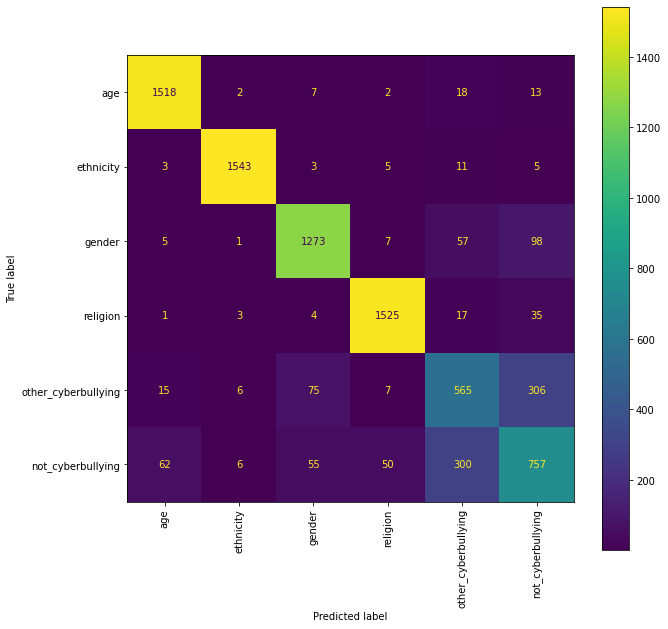

In [ ]:
model_test_scores = np.array(model_test_scores)
ensemble_scores = np.mean(model_test_scores, axis=0)
ensemble_prediction = np.argmax(ensemble_scores, axis=-1) # argmax across classes

evaluate_results(test_labels, ensemble_prediction)

# Weighted Average Model
All classifiers are more or less equally good but, in order to make the most of the ensemble technique, it is smarter to take a weighted average of the predictions so that the best classifiers have higher weights than the worst classifiers.

We are gonna use two different techniques in order to find the best weights of the model. In all the two experiments we will build two models: one which will maximize the accuracy on the validation set and one that will maximize the precision on no tumor image.

## Brute force
One way to found a good set of weights is to try all the weights within a certain step (respecting the constraint that the sum of all the weights needs to be 1) and try all the combinations keeping only the models with the best results on the validation set. Since we have 6 model, choosing a not small step size (0.05), this approach is feasible in a moderate time, but since the algorithmic complexity of this solution is O((1/step)^n), where n is the number of models, this approach becomes unfeasible if the number of model is higher or we want an higher precision decreasing the step size.


The following function will allow us to calculate the weighted average of the predictions of the classifiers. 

In [ ]:
def calculate_ensemble_prediction(model_scores, weights):
  model_scores = np.array(model_scores)
  ensemble_scores = np.average(model_scores, axis=0, weights=weights)
  ensemble_prediction = np.argmax(ensemble_scores, axis=-1) # argmax across classes
  return ensemble_prediction

In [ ]:
def compare_model(modelA, modelB, param1, param2):
  """
  return the best model between modelA and modelB considering first param1 and the param2
  """
  if modelA[param1] > modelB[param1]:
    return modelA
  if modelA[param1] < modelB[param1]:
    return modelB
  #in case of tie we return the best model wrt param2
  return modelA if modelA[param2] > modelB[param2] else modelB

In [ ]:
step = 0.01

#record of the best model wrt accuracy on test set
best_accuracy_model = {'weights':[], 'accuracy':0, 'precision_on_notcyberbullying':0 }

#records of the best model wrt precision on test set
best_precision_model = {'weights':[], 'accuracy':0, 'precision_on_notcyberbullying':0 }

for a in np.arange(0,1.0001,step):
  for b in np.arange(0,1.0001,step):
    for c in np.arange(0,1.0001,step):
      for d in np.arange(0,1.0001,step):
        if (a + b + c + d == 1):
          predictions = calculate_ensemble_prediction(model_val_scores, [a, b, c, d])
          acc, prec = get_accuracy_and_notcyberbullying_precision(val_labels, predictions)
          new_model = {'weights':[a,b,c,d], 'accuracy':acc, 'precision_on_notcyberbullying':prec}
          best_accuracy_model = compare_model(best_accuracy_model, new_model, 'accuracy', 'precision_on_notcyberbullying')
          best_precision_model = compare_model(best_precision_model, new_model, 'precision_on_notcyberbullying', 'accuracy')

The weights of the two models found are printed below.

In [ ]:
best_accuracy_model

{'weights': [0.14, 0.17, 0.09, 0.6],
 'accuracy': 0.7878885662041519,
 'precision_on_notcyberbullying': 0.648}

In [ ]:
best_precision_model

{'weights': [0.11, 0.17, 0.08, 0.64],
 'accuracy': 0.7873507583091319,
 'precision_on_notcyberbullying': 0.6501623376623377}

The results of the two models are the following:

Model with best accuracy: 
Weights: [0.14, 0.17, 0.09, 0.6]
Accuracy on the set: 0.8632775119617225
                     precision    recall  f1-score   support

                age     0.9456    0.9814    0.9632      1560
          ethnicity     0.9936    0.9815    0.9875      1570
             gender     0.8933    0.8945    0.8939      1441
           religion     0.9573    0.9609    0.9591      1585
other_cyberbullying     0.5951    0.5975    0.5963       974
  not_cyberbullying     0.6375    0.6106    0.6238      1230

           accuracy                         0.8633      8360
          macro avg     0.8371    0.8377    0.8373      8360
       weighted avg     0.8616    0.8633    0.8623      8360



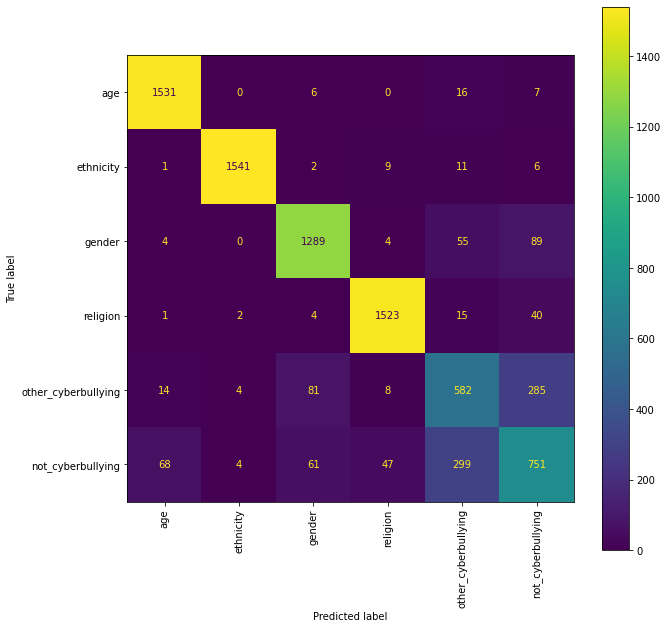

In [ ]:
print("Model with best accuracy: ")
print("Weights: " + str(best_accuracy_model['weights']))
best_acc_predictions = calculate_ensemble_prediction(model_test_scores, best_accuracy_model['weights'])
evaluate_results(test_labels, best_acc_predictions)

Model with best precision on not cyberbullying tweets: 
Weights: [0.11, 0.17, 0.08, 0.64]
Accuracy on the set: 0.8631578947368421
                     precision    recall  f1-score   support

                age     0.9451    0.9814    0.9629      1560
          ethnicity     0.9942    0.9815    0.9878      1570
             gender     0.8924    0.8924    0.8924      1441
           religion     0.9561    0.9609    0.9585      1585
other_cyberbullying     0.5975    0.6006    0.5991       974
  not_cyberbullying     0.6372    0.6098    0.6232      1230

           accuracy                         0.8632      8360
          macro avg     0.8371    0.8378    0.8373      8360
       weighted avg     0.8615    0.8632    0.8622      8360



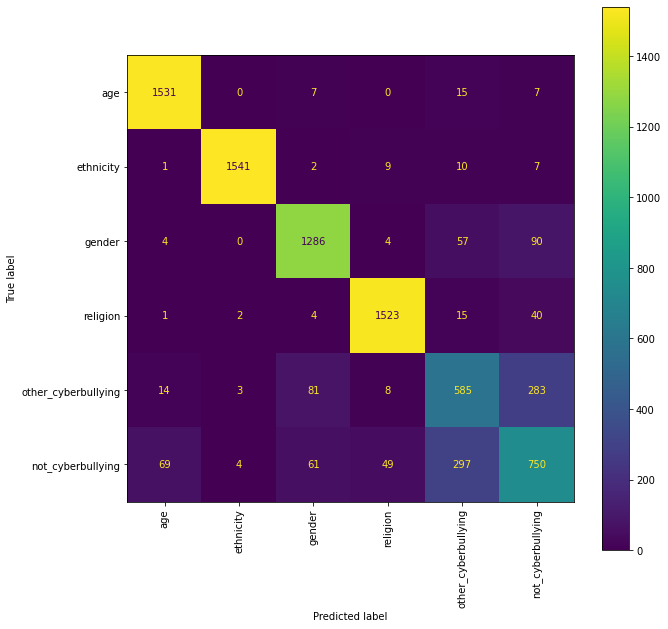

In [ ]:
print("Model with best precision on not cyberbullying tweets: ")
print("Weights: " + str(best_precision_model['weights']))
best_prec_predictions = calculate_ensemble_prediction(model_test_scores, best_precision_model['weights'])
evaluate_results(test_labels, best_prec_predictions)